In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from sklearn import linear_model
from sklearn.linear_model import lasso_path
from warnings import filterwarnings
filterwarnings('ignore')

np.random.seed(2022)

def extract_temp(file_name,col_ind):
    data_aux = np.loadtxt(file_name, usecols=range(10))
    data = data_aux[:,col_ind]
    err_count = 0
    ind_errs = []
    for ind in range(data.shape[0]):
        if data[ind] > 100 or data[ind] < -100:
            err_count = err_count + 1
            ind_errs.append(ind)
            data[ind] = data[ind-1]  
    print("File name: " + file_name)
    print("Errors: " + str(err_count) + " Indices: " + str(ind_errs))
    return data

def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind = 8 # 8 = last 5 minutes, 9 = average over the whole hour
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            ind = ind + 1
            data_aux = extract_temp(str_path + file_name,col_ind)
            if len(data_matrix) == 0:
                data_matrix = data_aux
            else:
                data_matrix = np.vstack((data_matrix,data_aux))
    return data_matrix.T

def corr(x,y):
    return abs(x.dot(y))

In [2]:
str_path = "./weather/"
load_files = False
if load_files:
    str_path_2015 = str_path + "hourly/2015/"
    data_matrix = create_data_matrix(str_path_2015)
else:
    data_matrix = np.load(str_path +"hourly_temperature_2015.npy")

file_name_list = listdir(str_path + "hourly/2015/")
file_name_list.sort()
cities = [c.split("-")[2].rsplit("_", 2)[0] for c in file_name_list]


ind_response = 100
print("Response is " + str(cities[ind_response]))
y_raw = data_matrix[:,ind_response]
ind_X = np.hstack((np.arange(0,ind_response),np.arange(ind_response+1,data_matrix.shape[1])))
X_raw = data_matrix[:,ind_X]
n_features = X_raw.shape[1]

n_test = int(1e3)
n_val = int(1e3)
n_train = 200
train_error_lasso_vec = []
val_error_lasso_vec = []
test_error_lasso_vec = []
train_error_ridge_vec = []
val_error_ridge_vec = []
test_error_ridge_vec = []

train_error_fsr_vec = []
val_error_fsr_vec = []
test_error_fsr_vec = []
test_2016_fsr_vec = []

coeffs_lasso_matrix = np.zeros(n_features)
coeffs_ridge_matrix = np.zeros(n_features)
lambda_lasso_vec = []
lambda_ridge_vec = []

n_lambda = 50
lambdas_ridge_aux = np.logspace(-5, 2, n_lambda)
lambdas_lasso = np.logspace(-5, 2, n_lambda)
eps = 1e-5  # the smaller it is the longer is the path


Response is OR_Corvallis


In [3]:

lambdas_ridge = lambdas_ridge_aux * n_train
aux_ind = np.random.permutation(range(data_matrix.shape[0]))
ind_test = aux_ind[:n_test]
ind_val = aux_ind[n_test:(n_test+n_val)]
X_test = X_raw[ind_test,:]
y_test = y_raw[ind_test]
X_val = X_raw[ind_val,:]
y_val = y_raw[ind_val]
ind_train = aux_ind[(n_test+n_val):int(n_test+n_val+n_train)]
X_train = X_raw[ind_train,:]
y_train = y_raw[ind_train]

center_vec = X_train.mean(axis=0)
X_train_centered = X_train - center_vec
col_norms = np.linalg.norm(X_train_centered, axis=0) / np.sqrt(n_train)
X_train_norm = np.true_divide(X_train_centered, col_norms)
X_test_centered = X_test - center_vec
X_test_norm = np.true_divide(X_test_centered, col_norms)
X_val_centered = X_val - center_vec
X_val_norm = np.true_divide(X_val_centered, col_norms)
y_train_center = y_train.mean()
y_train_centered = y_train - y_train_center
norm_y_train = np.linalg.norm(y_train_centered) / np.sqrt(n_train)
y_train_norm = y_train_centered / norm_y_train


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(200, 133)
(1000, 133)
(1000, 133)


In [4]:
def get_ridge_coef(X_train, y_train, lambda_reg):
    a =np.cov(X_train.T) + (lambda_reg/y_train.shape[0])*np.identity(X_train.shape[1])  
    cov = lambda x,y: (x * y).mean() - x.mean() * y.mean()
    b  = np.array([cov(X_train[:,x],y_train) for x in range(X_train.shape[1]) ] )
    return np.linalg.inv(a)@b
    #return linear_model.Ridge(alpha=lambda_reg).fit(X_train, y_train).coef_
clf = linear_model.Lasso(alpha=0.1)
get_lasso_coef = lambda X_train, y_train, lambda_reg: linear_model.Lasso(alpha=lambda_reg).fit(X_train, y_train).coef_
def get_splits_n(n):
    train_ind = np.random.randint(0 ,X_train.shape[0], size=n)
    test_ind = np.random.randint(0, X_test.shape[0], size=n)
    x_train_n = X_train[train_ind]
    y_train_n = y_train[train_ind]
    x_test_n = X_test[train_ind]
    y_test_n = y_test[test_ind]
    return  x_train_n ,y_train_n ,x_test_n ,y_test_n 
x_train_n ,y_train_n ,x_test_n ,y_test_n = get_splits_n(100)
def rmse(X_train, y_train, coef):
    return np.sqrt(np.mean((y_train - X_train@coef )**2))
coef = get_lasso_coef(x_train_n, y_train_n, lambda_reg=.1)
rmse(x_train_n, y_train_n , coef)
get_linear_coef = lambda X_train, y_train: linear_model.LinearRegression().fit(X_train, y_train).coef_

In [5]:
from itertools import product
lasso_rmse = {}
ridge_rmse = {}
lasso_test = {}
ridge_test = {}
linear = {}
linear_test = {}
best_ridge_coefs = {}
lambda_list =[10**(-5)
, 10**(-4)
, 10**(-3)
, 10**(-2)
, 10**(-1)
, 1, 10, 100]
samples_list = [200,600,2000]   
models = {0:"linear", 1: "lasso", 2:"ridge"}
settings = product(lambda_list , samples_list)
best_models = {}
best_lasso_coefs = {}
for setting in settings:
    x_train_n ,y_train_n ,x_test_n ,y_test_n = get_splits_n(setting[1])
    lasso_coef = get_lasso_coef(x_train_n, y_train_n, lambda_reg=setting[0])
    ridge_coef = get_ridge_coef(x_train_n, y_train_n, lambda_reg=setting[0])
for n in samples_list:
    ridge = []
    lasso = []
    ridge_t = []
    lasso_t = []
    lasso_coefs = []
    ridge_coefs = []
    x_train_n ,y_train_n ,x_test_n ,y_test_n = get_splits_n(n)
    linear_coef = get_linear_coef(x_train_n, y_train_n )
    linear_rmse = rmse(x_test_n, y_test_n, linear_coef)
    for lambda_reg in lambda_list:    
        lasso_coef = get_lasso_coef(x_train_n, y_train_n, lambda_reg=lambda_reg)
        lasso_coefs.append(lasso_coef)
        ridge_coef = get_ridge_coef(x_train_n, y_train_n, lambda_reg=lambda_reg)
        ridge_coefs.append(ridge_coef)
        ridge.append(rmse(x_train_n, y_train_n, ridge_coef))
        r_rmse = rmse(x_test_n, y_test_n, ridge_coef)
        l_rmse = rmse(x_test_n, y_test_n, lasso_coef)
        lasso.append(rmse(x_train_n, y_train_n, lasso_coef))
        ridge_t.append(rmse(x_test_n, y_test_n, ridge_coef))
        lasso_t.append(rmse(x_test_n, y_test_n, lasso_coef))
        #print(np.argmin(linear_rmse, l_rmse, r_rmse))
        best_models[(n , lambda_reg)] = models[np.argmin([linear_rmse, l_rmse, r_rmse])]

        #print(print(" lowest rmse for {0} samples and lambda = {1} was {2}".format(n, lambda_reg , min(linear_rmse, lasso_rmse, ) )) 
    lasso_coefs = np.array(lasso_coefs)
    ridge_coefs = np.array(ridge_coefs)
    def abs_sorted(l):
        return np.argsort(np.absolute(l))[:5]
    best_lasso_coefs[n] = lasso_coefs
    best_ridge_coefs[n] = ridge_coefs

    print(print(" rmse for OLS train with {0} samples was {1}".format(n,lambda_list[np.argmin(lasso)])))   
    print(print("lowest rmse for ridge train with {0} samples was achived at {1}".format(n,lambda_list[np.argmin(ridge)])))   
    print(print("lowest rmse for lasso train with {0} samples was achived {1}".format(n,lambda_list[np.argmin(lasso)])))   
    print(print("lowest rmse for ridge train with {0} samples was achived {1}".format(n,lambda_list[np.argmin(ridge)])))   
    print(print("lowest rmse for lasso test with {0} samples was achived at {1}".format(n,lambda_list[np.argmin(lasso_t)])))   
    print(print("lowest rmse for ridge test with {0} samples was achived {1}".format(n,lambda_list[np.argmin(ridge_t)])))    
    lasso_rmse[n]=lasso
    ridge_rmse[n]=ridge
    ridge_test[n]=ridge_t
    lasso_test[n]=lasso_t
    linear[n] =rmse(x_train_n, y_train_n, linear_coef)
    linear_test[n]=rmse(x_test_n, y_test_n, linear_coef)
    

 rmse for OLS train with 200 samples was 0.1
None
lowest rmse for ridge train with 200 samples was achived at 10
None
lowest rmse for lasso train with 200 samples was achived 0.1
None
lowest rmse for ridge train with 200 samples was achived 10
None
lowest rmse for lasso test with 200 samples was achived at 1
None
lowest rmse for ridge test with 200 samples was achived 100
None
 rmse for OLS train with 600 samples was 1e-05
None
lowest rmse for ridge train with 600 samples was achived at 10
None
lowest rmse for lasso train with 600 samples was achived 1e-05
None
lowest rmse for ridge train with 600 samples was achived 10
None
lowest rmse for lasso test with 600 samples was achived at 1
None
lowest rmse for ridge test with 600 samples was achived 100
None
 rmse for OLS train with 2000 samples was 0.1
None
lowest rmse for ridge train with 2000 samples was achived at 100
None
lowest rmse for lasso train with 2000 samples was achived 0.1
None
lowest rmse for ridge train with 2000 samples wa

In [6]:
samples_list

[200, 600, 2000]

In [7]:
lambda_list

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

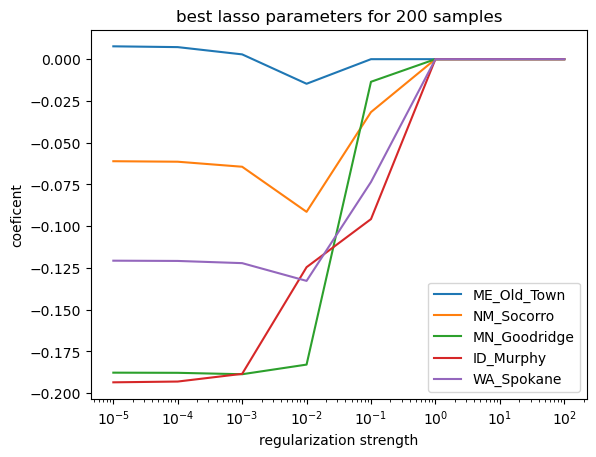

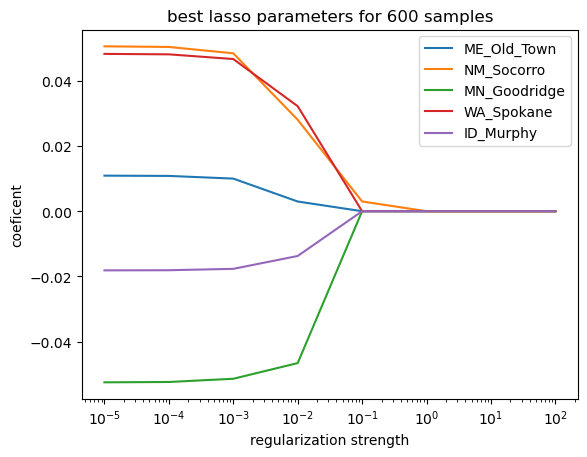

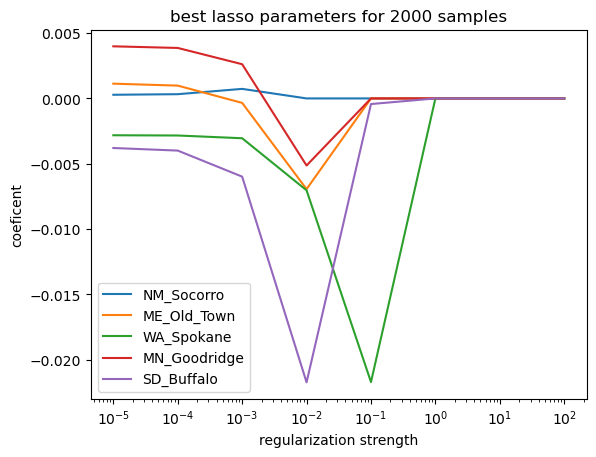

(3, 8, 5)

In [16]:
def abs_sorted(l):
    return np.argsort(np.absolute(l))[:5]
best_lasso_indecies = np.array(list(map(abs_sorted, lasso_coefs)))

array = np.array(list(best_lasso_coefs.values())) #3,8,5
best_lasso_indecies.shape # 8,5
array = array[:,:,best_lasso_indecies[1]]
array.shape
for n in range(array.shape[0]):
    for dim in range(array.shape[2]):
        plt.plot(lambda_list, array[n, :,dim ], label=np.array(cities)[best_lasso_indecies[n , dim]  ] )
            # plt.ylabel("coefcent magnitude")
            # plt.xlabel("num samples")
    plt.xscale("log")
    plt.legend()
    plt.xlabel("regularization strength")
    plt.ylabel("coeficent")
    plt.title("best lasso parameters for {0} samples".format(samples_list[n]))
    plt.show()
    #print(test)
array.shape

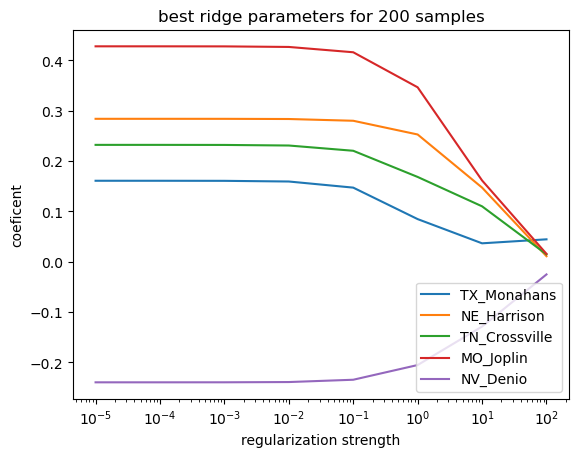

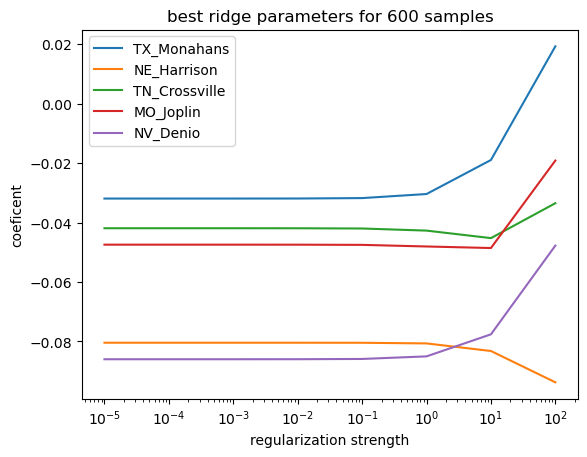

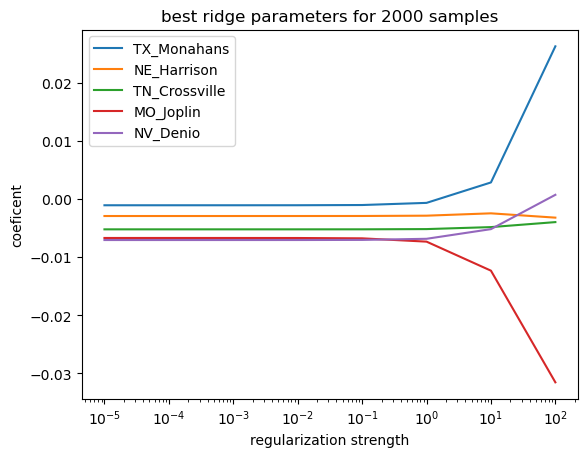

In [9]:
def abs_sorted(l):
    return np.argsort(np.absolute(l))[:5]
best_ridge_indecies = np.array(list(map(abs_sorted, ridge_coefs)))

array = np.array(list(best_ridge_coefs.values())) #3,8,5
best_ridge_indecies.shape # 8,5
array = array[:,:,best_ridge_indecies[1]]
array.shape
for n in range(array.shape[0]):
    for dim in range(array.shape[2]):
        plt.plot(lambda_list, array[n, :,dim ], label=np.array(cities)[best_ridge_indecies[n, dim]])
            # plt.ylabel("coefcent magnitude")
            # plt.xlabel("num samples")
    plt.xscale("log")
    plt.legend()
    plt.xlabel("regularization strength")
    plt.ylabel("coeficent")
    plt.title("best ridge parameters for {0} samples".format(samples_list[n]))
    plt.show()


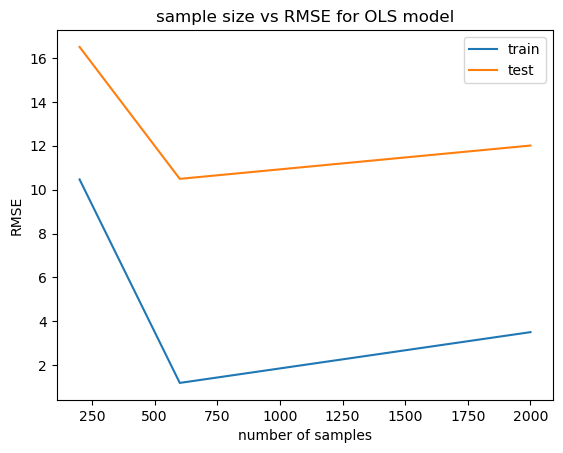

In [10]:
plt.plot(samples_list, linear.values(), label= "train")
plt.plot(samples_list, linear_test.values(), label= "test")
#plt.xscale("log")
plt.ylabel("RMSE")
plt.xlabel("number of samples")
plt.title("sample size vs RMSE for OLS model")
plt.legend()
plt.show()

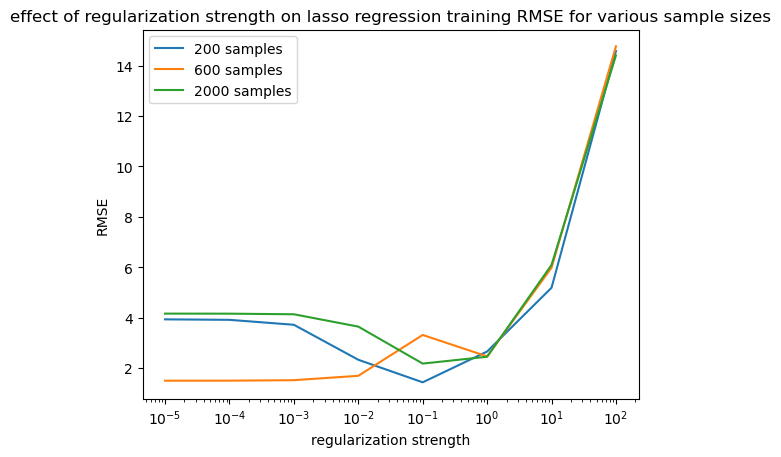

In [11]:
for lambda_reg in samples_list:
    plt.plot(lambda_list, lasso_rmse[lambda_reg], label = "{} samples".format(lambda_reg))
    #plt.plot(lambda_list, ridge_rmse[lambda_reg], label = "ridge with {} samples".format(lambda_reg))
    plt.xscale("log")
    plt.ylabel("RMSE")
    plt.xlabel("regularization strength")
    plt.title("effect of regularization strength on lasso regression training RMSE for various sample sizes")
plt.legend()  
plt.show()

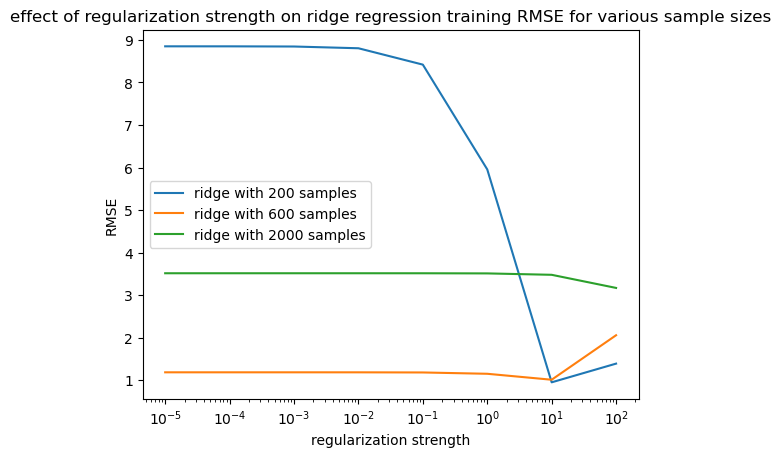

In [12]:
for lambda_reg in samples_list:
    #plt.plot(lambda_list, lasso_rmse[lambda_reg], label = "{} samples".format(lambda_reg))
    plt.plot(lambda_list, ridge_rmse[lambda_reg], label = "ridge with {} samples".format(lambda_reg))
    plt.xscale("log")
    plt.ylabel("RMSE")
    plt.xlabel("regularization strength")
    plt.title("effect of regularization strength on ridge regression training RMSE for various sample sizes")
plt.legend()  
plt.show()

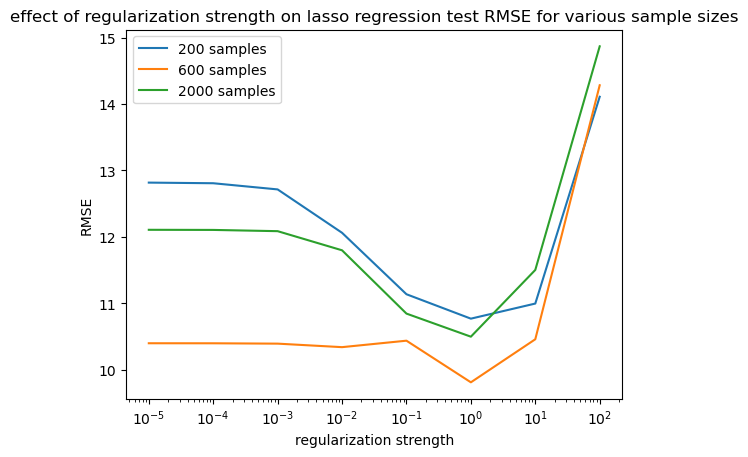

In [13]:
for lambda_reg in samples_list:
    plt.plot(lambda_list, lasso_test[lambda_reg], label = "{} samples".format(lambda_reg))
    #plt.plot(lambda_list, ridge_rmse[lambda_reg], label = "ridge with {} samples".format(lambda_reg))
    plt.xscale("log")
    plt.ylabel("RMSE")
    plt.xlabel("regularization strength")
    plt.title("effect of regularization strength on lasso regression test RMSE for various sample sizes")
plt.legend()  
plt.show()

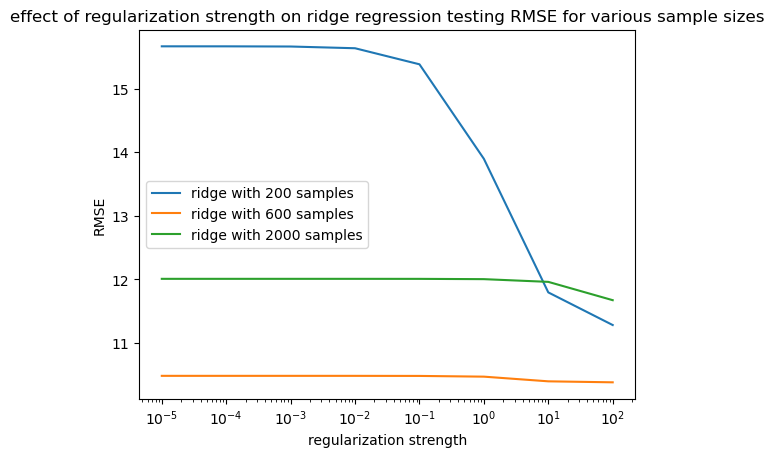

In [14]:
for lambda_reg in samples_list:
    #plt.plot(lambda_list, lasso_rmse[lambda_reg], label = "{} samples".format(lambda_reg))
    plt.plot(lambda_list, ridge_test[lambda_reg], label = "ridge with {} samples".format(lambda_reg))
    plt.xscale("log")
    plt.ylabel("RMSE")
    plt.xlabel("regularization strength")
    plt.title("effect of regularization strength on ridge regression testing RMSE for various sample sizes")
plt.legend()  
plt.show()

In [15]:
best_lasso_coefs

{200: array([[ 0.48091049,  0.29560827,  0.09173057, ..., -0.1076855 ,
          0.12445197, -0.29860006],
        [ 0.47868772,  0.29554579,  0.09075193, ..., -0.10761978,
          0.12409772, -0.2980954 ],
        [ 0.45673263,  0.29434521,  0.08089176, ..., -0.10707594,
          0.12042604, -0.2930507 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 600: array([[-0.07247272,  0.3246642 ,  0.04248125, ...,  0.17535363,
          0.21477358, -0.12326202],
        [-0.07230177,  0.32381113,  0.04243402, ...,  0.17521644,
          0.21456819, -0.12302   ],
        [-0.07053277,  0.3153111 ,  0.04205674, ...,  0.17384524,
          0.21250966, -0.12065217],
        ...,
        [ 0.        ,  0.        ,  0.      